<a href="https://colab.research.google.com/github/alnasiman/Deteksi-Perundungan-Siber-Notebook/blob/main/Deteksi_Perundungan_Siber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. *Import Library*

In [1]:
!pip install numpy==1.26.4
!pip install transformers datasets scikit-learn emoji imbalanced-learn
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve,
    log_loss
)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import torch
from imblearn.over_sampling import RandomOverSampler
from transformers.trainer_utils import get_last_checkpoint

# 2. *Load Dataset*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv("/content/drive/MyDrive/dataset/Dataset Cyberbullying Bahasa Indonesia (Source Youtube)/Dataset_Youtube(Train Test).csv")
test_df = pd.read_csv("/content/drive/MyDrive/dataset/Dataset Cyberbullying Bahasa Indonesia (Source Youtube)/Dataset_Youtube(Train Val).csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
print('Data Latih')
print(train_df['Label'].value_counts())
train_df

Data Latih
Label
0    28534
1     2830
Name: count, dtype: int64


,Text,Label
0,Menurutku dalam bidang agama saya kurang seped...,0
1,Masih menanti keberanian pak Ganjar untuk mela...,0
2,puncak komedi 🤣,0
3,"saya, kita, gue, labil, cb fjr disugesti ferdi...",0
4,Kalau anak gua kaya gini gua cubit ginjal nya ..,1
...,...,...
31359,"asli cok, gw pusing 😭. apalah daya aku yg hany...",0
31360,Terimakasih MLI telah menghadirkan 3 tokoh ilm...,0
31361,Ngeri apaan🤣🤣🤣,0
31362,fajar kaya baru kelar uji nyali 🙏🙏🙏,0


In [4]:
print('Data Uji')
print(test_df['Label'].value_counts())
test_df

Data Uji
Label
0    19973
1     1981
Name: count, dtype: int64


,Text,Label
0,Di kasih tissue bukan ngelap aer mata malah ng...,0
1,@Fitry Yulyanaiya kwkwkw sama kwkwkwkw,0
2,Fajar ini baiknya di Ikat di tiang lalu di ruk...,0
3,"Besok senin , jangan lupa sekolah jar",0
4,Kudu ngguyu dewe...,0
...,...,...
21949,Masyallah fajar keren semoga sukses dunia akhirat,0
21950,"Kelebihan Fajar ada di dalam kesedihannya, saa...",0
21951,Klo diliat2 Fajar mukanya mirip manji waktu dulu,0
21952,Pin . Sebulan LG anak ini jadi tai .pasti,0


# 3. *Preprocessing*

In [5]:
nltk.download('stopwords')
stopwords_id = set(stopwords.words('indonesian'))

def clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(r"http\S+|www\S+", "", text) # remove url
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # remove symbol
    text = emoji.replace_emoji(text, "") # remove emoji
    text = re.sub(r"\s+", " ", text).strip() # remove space
    # stopword removal
    words = text.split()
    cleaned_words = [word for word in words if word not in stopwords_id]
    text = " ".join(cleaned_words)

    return text

train_df['cleaned'] = train_df['Text'].astype(str).apply(clean_text)
test_df['cleaned'] = test_df['Text'].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
print('Perbedaan Antara Teks Sebelum dan Sesudah Dibersihkan di Data Latih \n')
train_df[['Text', 'cleaned']]

Perbedaan Antara Teks Sebelum dan Sesudah Dibersihkan di Data Latih 



,Text,cleaned
0,Menurutku dalam bidang agama saya kurang seped...,menurutku bidang agama sepedapat karna merasak...
1,Masih menanti keberanian pak Ganjar untuk mela...,keberanian ganjar melawan mafia tambang galian...
2,puncak komedi 🤣,puncak komedi
3,"saya, kita, gue, labil, cb fjr disugesti ferdi...",gue labil cb fjr disugesti ferdian aj bg den
4,Kalau anak gua kaya gini gua cubit ginjal nya ..,anak gua kaya gini gua cubit ginjal nya
...,...,...
31359,"asli cok, gw pusing 😭. apalah daya aku yg hany...",asli cok gw pusing apalah daya yg manusia maks...
31360,Terimakasih MLI telah menghadirkan 3 tokoh ilm...,terimakasih mli menghadirkan 3 tokoh ilmuan fi...
31361,Ngeri apaan🤣🤣🤣,ngeri
31362,fajar kaya baru kelar uji nyali 🙏🙏🙏,fajar kaya kelar uji nyali


In [7]:
print('Perbedaan Antara Teks Sebelum dan Sesudah Dibersihkan di Data Uji \n')
test_df[['Text', 'cleaned']]

Perbedaan Antara Teks Sebelum dan Sesudah Dibersihkan di Data Uji 



,Text,cleaned
0,Di kasih tissue bukan ngelap aer mata malah ng...,kasih tissue ngelap aer mata ngelap kepala
1,@Fitry Yulyanaiya kwkwkw sama kwkwkwkw,fitry yulyanaiya kwkwkw kwkwkwkw
2,Fajar ini baiknya di Ikat di tiang lalu di ruk...,fajar baiknya ikat tiang rukyah cambuk anak wa...
3,"Besok senin , jangan lupa sekolah jar",besok senin lupa sekolah jar
4,Kudu ngguyu dewe...,kudu ngguyu dewe
...,...,...
21949,Masyallah fajar keren semoga sukses dunia akhirat,masyallah fajar keren semoga sukses dunia akhirat
21950,"Kelebihan Fajar ada di dalam kesedihannya, saa...",kelebihan fajar kesedihannya sedih fajar menge...
21951,Klo diliat2 Fajar mukanya mirip manji waktu dulu,klo diliat2 fajar mukanya manji
21952,Pin . Sebulan LG anak ini jadi tai .pasti,pin sebulan lg anak tai


In [8]:
# balancing data (only training data)
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(train_df[['cleaned']], train_df['Label'])
train_df_balanced = pd.DataFrame({'text': X_resampled['cleaned'], 'Label': y_resampled})

In [9]:
print('Jumlah Data Setelah Imbang \n')
abd = {'Kelas': ['Non-Bullying', 'Cyberbullying'],
        'Sebelum': [str(train_df['Label'].value_counts()[0]), str(train_df['Label'].value_counts()[1])],
        'Sesudah': [str(train_df_balanced['Label'].value_counts()[0]), str(train_df_balanced['Label'].value_counts()[1])]}

ABD = pd.DataFrame(abd)
print(ABD)

Jumlah Data Setelah Imbang 

           Kelas Sebelum Sesudah
0   Non-Bullying   28534   28534
1  Cyberbullying    2830   28534


In [10]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_df_balanced = train_df_balanced.rename(columns={"Label": "label"})
test_df = test_df.rename(columns={"Label": "label", "cleaned": "text"})

train_dataset = Dataset.from_pandas(train_df_balanced[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/57068 [00:00<?, ? examples/s]

Map:   0%|          | 0/21954 [00:00<?, ? examples/s]

# 4. *Model Training*

In [11]:
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=2,
    learning_rate=2e-5,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dev-rahmat15 (rahmad-alnasiman) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.162000,0.085326
2,0.092100,0.048689
3,0.036600,0.026440
4,0.040600,0.020709
5,0.026900,0.018981
6,0.037700,0.013976
7,0.008700,0.011752
8,0.019900,0.012088
9,0.005000,0.010045
10,0.009100,0.009119


TrainOutput(global_step=17840, training_loss=0.05933680709184152, metrics={'train_runtime': 4803.1077, 'train_samples_per_second': 118.815, 'train_steps_per_second': 3.714, 'total_flos': 3.75380542682112e+16, 'train_loss': 0.05933680709184152, 'epoch': 10.0})

# 5. *Evaluate Model*

In [12]:
predictions_output = trainer.predict(test_tokenized)
y_pred_logits = predictions_output.predictions
y_true = predictions_output.label_ids

y_probs = np.exp(y_pred_logits) / np.sum(np.exp(y_pred_logits), axis=1, keepdims=True)
y_pred = np.argmax(y_pred_logits, axis=1)

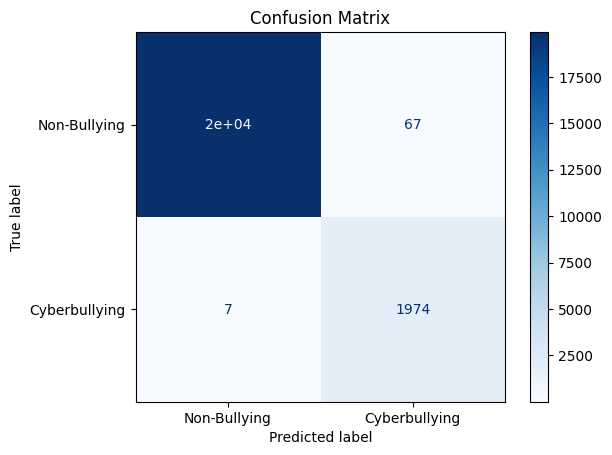

               precision    recall  f1-score   support

 Non-Bullying       1.00      1.00      1.00     19973
Cyberbullying       0.97      1.00      0.98      1981

     accuracy                           1.00     21954
    macro avg       0.98      1.00      0.99     21954
 weighted avg       1.00      1.00      1.00     21954



In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Bullying', 'Cyberbullying'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=['Non-Bullying', 'Cyberbullying']))

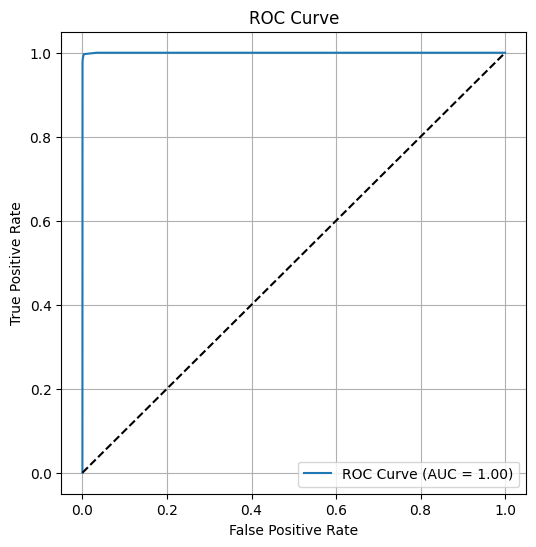

In [14]:
# ROC-AUC
y_positive_probs = y_probs[:, 1]

roc_auc = roc_auc_score(y_true, y_positive_probs)
fpr, tpr, thresholds = roc_curve(y_true, y_positive_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [15]:
# Log Loss
logloss = log_loss(y_true, y_probs)
print(f"Log Loss: {logloss:.4f}")

Log Loss: 0.0091


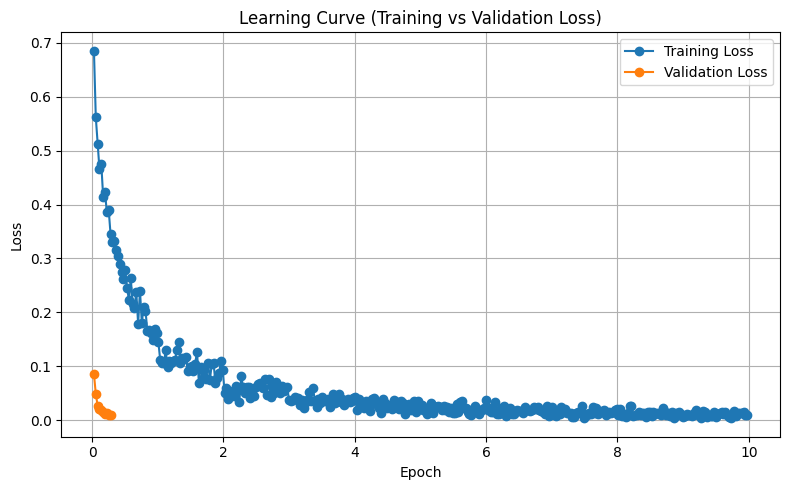

In [16]:
# Learning Curve
# Ambil history training dan evaluasi dari trainer
log_history = trainer.state.log_history

# Ekstrak data dari log
train_loss = []
eval_loss = []
epochs = []

for entry in log_history:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
        epochs.append(entry["epoch"])
    elif "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label="Training Loss", marker='o')
plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Training vs Validation Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Menghitung titik bawah, titik atas, dan standar deviasi dari Learning Curve

# Ambil log dari trainer
log_history = trainer.state.log_history

# Siapkan list
train_loss = []
eval_loss = []
epochs = []

# Ekstrak data
for log in log_history:
    if "loss" in log and "epoch" in log:
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    elif "eval_loss" in log and "epoch" in log:
        eval_loss.append(log["eval_loss"])

# Konversi ke NumPy array
train_loss = np.array(train_loss)
eval_loss = np.array(eval_loss)

# Fungsi ringkas untuk menghitung statistik
def summary_stats(arr, label="Loss"):
    print(f"\n📊 Statistik {label}")
    print(f"▶ Rata-rata     : {np.mean(arr):.4f}")
    print(f"▶ Titik Bawah   : {np.min(arr):.4f}")
    print(f"▶ Titik Atas    : {np.max(arr):.4f}")
    print(f"▶ Standar Deviasi: {np.std(arr):.4f}")

# Tampilkan statistik
summary_stats(train_loss, "Training Loss")
summary_stats(eval_loss, "Validation Loss")


📊 Statistik Training Loss
▶ Rata-rata     : 0.0594
▶ Titik Bawah   : 0.0031
▶ Titik Atas    : 0.6856
▶ Standar Deviasi: 0.0927

📊 Statistik Validation Loss
▶ Rata-rata     : 0.0257
▶ Titik Bawah   : 0.0091
▶ Titik Atas    : 0.0853
▶ Standar Deviasi: 0.0228


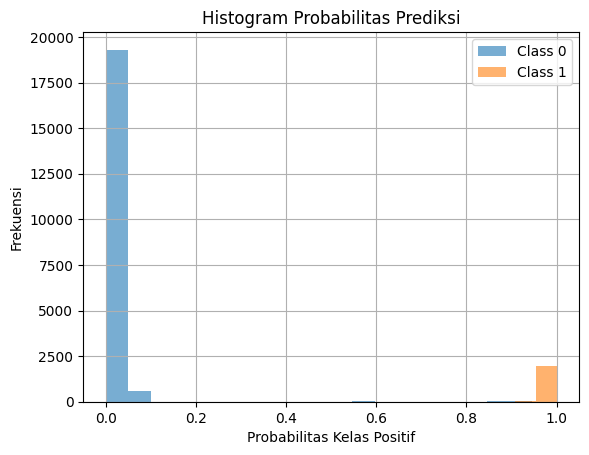

In [18]:
# Histogram
plt.hist(y_positive_probs[y_true == 0], bins=20, alpha=0.6, label='Class 0')
plt.hist(y_positive_probs[y_true == 1], bins=20, alpha=0.6, label='Class 1')
plt.title("Histogram Probabilitas Prediksi")
plt.xlabel("Probabilitas Kelas Positif")
plt.ylabel("Frekuensi")
plt.legend()
plt.grid()
plt.show()

# 6. *Deployment*

In [19]:
output_dir = "./indobert_cyberbullying_model_v2"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model disimpan di: {output_dir}")
!zip -r indobert_cyberbullying_model_v2.zip /content/indobert_cyberbullying_model_v2
!cp '/content/indobert_cyberbullying_model_v2.zip' '/content/drive/MyDrive/model AI/'

Model disimpan di: ./indobert_cyberbullying_model_v2
  adding: content/indobert_cyberbullying_model_v2/ (stored 0%)
  adding: content/indobert_cyberbullying_model_v2/special_tokens_map.json (deflated 42%)
  adding: content/indobert_cyberbullying_model_v2/config.json (deflated 55%)
  adding: content/indobert_cyberbullying_model_v2/model.safetensors (deflated 7%)
  adding: content/indobert_cyberbullying_model_v2/tokenizer_config.json (deflated 74%)
  adding: content/indobert_cyberbullying_model_v2/vocab.txt (deflated 53%)
